In [90]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np
from scipy.stats import skew
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling 
from lightgbm import LGBMClassifier

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
# memory management
import gc

from math import sqrt
import os

In [91]:
os.chdir("D:\data\Jupyter Notebook\kaggle\Home-Credit-Default-Risk")

### 前処理済データ読み込み

In [92]:
# Read in data
train = pd.read_csv('m_train.csv')
test = pd.read_csv('m_test.csv')

In [93]:
y_train = train['TARGET']
train = train.drop('TARGET',axis=1)

In [94]:
x_train = train.fillna(train.median())
x_test = test.fillna(test.median())

In [95]:
ntrain = x_train.shape[0]
ntest = x_test.shape[0]

In [96]:
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

In [97]:
excluded_feats = ['SK_ID_CURR']
features = [f_ for f_ in x_train.columns if f_ not in excluded_feats]

In [98]:
x_train = x_train[features]
x_test = x_test[features]

In [99]:
x_train_first = x_train
x_test_first = x_test

In [100]:
NFOLDS = 3
SEED = 0
NROWS = None
kf = KFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)

In [101]:
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

class CatboostWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]
        
class LightGBMWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]


class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

In [102]:
def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        x_te = x_train.loc[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [103]:
et_params = {
    'n_jobs': 16,
    'n_estimators': 200,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

rf_params = {
    'n_jobs': 16,
    'n_estimators': 200,
    'max_features': 0.2,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'binary:logistic',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'nrounds': 200
}

catboost_params = {
    'iterations': 200,
    'learning_rate': 0.5,
    'depth': 3,
    'l2_leaf_reg': 40,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.7,
    'scale_pos_weight': 5,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'allow_writing_files': False
}

lightgbm_params = {
    'n_estimators':200,
    'learning_rate':0.1,
    'num_leaves':123,
    'colsample_bytree':0.8,
    'subsample':0.9,
    'max_depth':15,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'min_split_gain':0.01,
    'min_child_weight':2    
}

In [104]:
xg = XgbWrapper(seed=SEED, params=xgb_params)
et = SklearnWrapper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
rf = SklearnWrapper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
cb = CatboostWrapper(clf= CatBoostClassifier, seed = SEED, params=catboost_params)
lg = LightGBMWrapper(clf = LGBMClassifier, seed = SEED, params = lightgbm_params)

In [105]:
#xg_oof_train, xg_oof_test = get_oof(xg)
et_oof_train, et_oof_test = get_oof(et)
rf_oof_train, rf_oof_test = get_oof(rf)
cb_oof_train, cb_oof_test = get_oof(cb)

0:	total: 218ms	remaining: 43.5s
1:	total: 435ms	remaining: 43.1s
2:	total: 655ms	remaining: 43s
3:	total: 871ms	remaining: 42.7s
4:	total: 1.08s	remaining: 42.1s
5:	total: 1.29s	remaining: 41.7s
6:	total: 1.5s	remaining: 41.4s
7:	total: 1.71s	remaining: 41.1s
8:	total: 1.92s	remaining: 40.8s
9:	total: 2.13s	remaining: 40.5s
10:	total: 2.36s	remaining: 40.6s
11:	total: 2.58s	remaining: 40.4s
12:	total: 2.78s	remaining: 40s
13:	total: 3s	remaining: 39.9s
14:	total: 3.22s	remaining: 39.7s
15:	total: 3.44s	remaining: 39.6s
16:	total: 3.67s	remaining: 39.5s
17:	total: 3.94s	remaining: 39.8s
18:	total: 4.17s	remaining: 39.8s
19:	total: 4.39s	remaining: 39.5s
20:	total: 4.6s	remaining: 39.2s
21:	total: 4.82s	remaining: 39s
22:	total: 5.07s	remaining: 39s
23:	total: 5.32s	remaining: 39s
24:	total: 5.57s	remaining: 39s
25:	total: 5.82s	remaining: 38.9s
26:	total: 6.04s	remaining: 38.7s
27:	total: 6.26s	remaining: 38.5s
28:	total: 6.48s	remaining: 38.2s
29:	total: 6.69s	remaining: 37.9s
30:	tot

42:	total: 9.56s	remaining: 34.9s
43:	total: 9.79s	remaining: 34.7s
44:	total: 10s	remaining: 34.4s
45:	total: 10.2s	remaining: 34.2s
46:	total: 10.4s	remaining: 33.9s
47:	total: 10.6s	remaining: 33.7s
48:	total: 10.9s	remaining: 33.5s
49:	total: 11.1s	remaining: 33.3s
50:	total: 11.3s	remaining: 33s
51:	total: 11.5s	remaining: 32.8s
52:	total: 11.7s	remaining: 32.6s
53:	total: 12s	remaining: 32.4s
54:	total: 12.2s	remaining: 32.3s
55:	total: 12.5s	remaining: 32.2s
56:	total: 12.8s	remaining: 32.1s
57:	total: 13.1s	remaining: 32s
58:	total: 13.3s	remaining: 31.8s
59:	total: 13.6s	remaining: 31.7s
60:	total: 13.8s	remaining: 31.5s
61:	total: 14.1s	remaining: 31.3s
62:	total: 14.3s	remaining: 31.1s
63:	total: 14.5s	remaining: 30.8s
64:	total: 14.7s	remaining: 30.6s
65:	total: 15s	remaining: 30.4s
66:	total: 15.2s	remaining: 30.1s
67:	total: 15.4s	remaining: 29.9s
68:	total: 15.6s	remaining: 29.7s
69:	total: 15.8s	remaining: 29.4s
70:	total: 16.1s	remaining: 29.2s
71:	total: 16.3s	remaini

83:	total: 18.9s	remaining: 26.1s
84:	total: 19.1s	remaining: 25.9s
85:	total: 19.4s	remaining: 25.7s
86:	total: 19.6s	remaining: 25.4s
87:	total: 19.8s	remaining: 25.2s
88:	total: 20s	remaining: 25s
89:	total: 20.3s	remaining: 24.8s
90:	total: 20.5s	remaining: 24.6s
91:	total: 20.7s	remaining: 24.3s
92:	total: 20.9s	remaining: 24.1s
93:	total: 21.1s	remaining: 23.8s
94:	total: 21.3s	remaining: 23.6s
95:	total: 21.6s	remaining: 23.3s
96:	total: 21.8s	remaining: 23.1s
97:	total: 22s	remaining: 22.9s
98:	total: 22.2s	remaining: 22.7s
99:	total: 22.5s	remaining: 22.5s
100:	total: 22.8s	remaining: 22.3s
101:	total: 23s	remaining: 22.1s
102:	total: 23.2s	remaining: 21.8s
103:	total: 23.4s	remaining: 21.6s
104:	total: 23.6s	remaining: 21.4s
105:	total: 23.8s	remaining: 21.1s
106:	total: 24.1s	remaining: 20.9s
107:	total: 24.3s	remaining: 20.7s
108:	total: 24.5s	remaining: 20.5s
109:	total: 24.7s	remaining: 20.2s
110:	total: 25s	remaining: 20s
111:	total: 25.2s	remaining: 19.8s
112:	total: 25

In [108]:
#print("XG-CV: {}".format(sqrt(mean_squared_error(y_train, xg_oof_train))))
print("ET-CV: {}".format(sqrt(mean_squared_error(y_train, et_oof_train))))
print("RF-CV: {}".format(sqrt(mean_squared_error(y_train, rf_oof_train))))
print("RF-CV: {}".format(sqrt(mean_squared_error(y_train, cb_oof_train))))

ET-CV: 0.26204598466138296
RF-CV: 0.2617941143339201
RF-CV: 0.327318699834669


In [109]:
x_train = np.concatenate((et_oof_train, rf_oof_train, cb_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, cb_oof_test), axis=1)
print("{},{}".format(x_train.shape, x_test.shape))

(307511, 3),(48744, 3)


In [110]:
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

In [111]:
x_train = pd.concat([x_train,x_train_first],axis=1)
x_test = pd.concat([x_test,x_test_first],axis=1)
x_train_second = pd.concat([x_train,train_ids],axis=1)
x_test_second = pd.concat([x_test,test_ids],axis=1)
# TARGET列を再びくっつける
x_train_second['TARGET'] = y_train
print("{},{}".format(x_train_second.shape, x_test_second.shape))

(307511, 546),(48744, 545)


In [113]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [114]:
submission, feature_importances, metrics = model(x_train_second,x_test_second)

Training Data Shape:  (307511, 544)
Testing Data Shape:  (48744, 544)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.778964	train's auc: 0.825009
Early stopping, best iteration is:
[105]	valid's auc: 0.779588	train's auc: 0.804727
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.782136	train's auc: 0.824278
Early stopping, best iteration is:
[205]	valid's auc: 0.782173	train's auc: 0.825158
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.774097	train's auc: 0.826585
[400]	valid's auc: 0.774454	train's auc: 0.862687
Early stopping, best iteration is:
[410]	valid's auc: 0.774539	train's auc: 0.864175
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.779548	train's auc: 0.825415
Early stopping, best iteration is:
[159]	valid's auc: 0.779752	train's auc: 0.816823
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.7798

In [115]:
metrics

,fold,train,valid
0,0,0.804727,0.779588
1,1,0.825158,0.782173
2,2,0.864175,0.774539
3,3,0.816823,0.779752
4,4,0.857574,0.780220
5,overall,0.833691,0.778890


In [116]:
submission.to_csv('submission_stacking_2.csv', index = False)

In [88]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

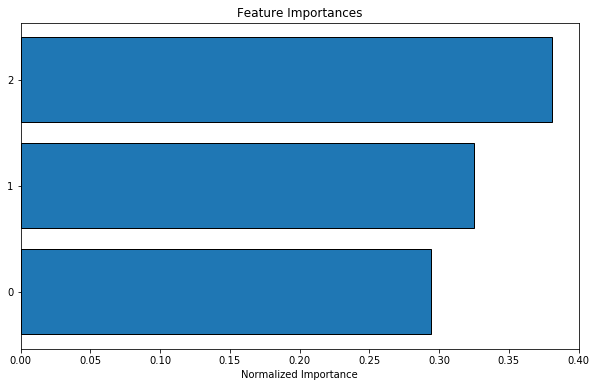

In [89]:
feature_importances_sorted = plot_feature_importances(feature_importances)

### トレーニング・テストデータの出力

In [ ]:
train.to_csv('m_train.csv', index = False)
test.to_csv('m_test.csv', index = False)

In [ ]:
train_imp.to_csv('m_train_imp.csv', index = False)
test_imp.to_csv('m_test_imp.csv', index = False)

### アンサンブル

In [ ]:
submission

In [ ]:
submission_ensemble = submission.copy().drop(['TARGET'],axis=1)
submission_ensemble['TARGET'] = (submission['TARGET'] + x_train_first['et']+ x_train_first['rf'])/3
submission_ensemble['SK_ID_CURR']
submission_ensemble.to_csv('submission_ensemble.csv', index = False)